## Part 1 Build Dataset

In [1]:
import tools
import pickle
import numpy as np

def make_sorted_list_and_save(days):
    pickle_in = open("stock_price_dict.pickle","rb")
    price_dict_ = pickle.load(pickle_in)
    #DATA_DIR = 'D:\Dataset\EarningsCallData\ReleasedDataset\ReleasedDataset_mp3'
    DATA_DIR = '.\EarningsCallData\ACL19_Release\ACL19_Release'
    stock_movement_3days, text_all, date, company = tools.calculate_movement(price_dict_, days, DATA_DIR)
    print(len(stock_movement_3days), len(text_all), len(date))

    combined_list = list(zip(date, stock_movement_3days, company, text_all)) #进行数据的聚合、组合或并行处理。
    print(len(combined_list))
    sorted_list = sorted(combined_list, key=lambda x: x[0])#按照列表中元素的第一个索引（日期）进行排序

    np.save(f'sorted_list_{days}days.npy', sorted_list)

def make_and_save(days):
    make_sorted_list_and_save(days)

if __name__ == "__main__":
    print()
    make_and_save(3)

  4%|▍         | 24/572 [00:00<00:13, 39.17it/s]

Error Company: Aetna IncDate: 2017-01-31
Error Company: Aetna IncDate: 2017-05-02
Error Company: Aetna IncDate: 2017-10-31


 17%|█▋        | 99/572 [00:01<00:06, 73.93it/s]

Error Company: CA, Inc.Date: 2017-08-02


 97%|█████████▋| 554/572 [00:09<00:00, 45.73it/s]

Error Company: Vulcan MaterialsDate: 2017-08-02


100%|██████████| 572/572 [00:10<00:00, 55.24it/s]


24.237429941531154
563 563 563
563


## Part 2 Token-Level Encoder

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
from tqdm import tqdm #用于在循环迭代中显示进度条的库
import torch
import re

#Generate sentence representation 使用预训练的语言模型来计算文本的嵌入表示
def replace_large_values(input_ids):
    new_ids = input_ids.clone()
    for i in range(len(input_ids)):
        for j in range(len(input_ids[i])):
            if new_ids[i, j] > 10 and j + 1 < len(input_ids[i]):
                new_ids[i, j] = input_ids[i, j + 1]
    return new_ids

def emb_str(text_list):
    text = "\n".join(text_list)
    input_ids = torch.tensor([tokenizer.encode(text, truncation=True, max_length=512)])  # 不需要 add_special_tokens=True

    with torch.no_grad():
        outputs = model.bert(input_ids)  # 使用 model.bert 来提取 BERT 模型的输出
        last_hidden_states = outputs.last_hidden_state
        emb = last_hidden_states.cpu().numpy()

    return emb
       
# Padding
def make(days,name):
    list = np.load(f"{name}_list_{days}days.npy")
    embs = []
    labels = []
    sentence_len = []
    features = []
    for i in tqdm(range(len(list))):
        # print(list[i])
        text = (list[i][2] + "\n" + list[i][3]).split("\n")#company \n text contnent
        sentence_len.append(len(text))
        text_embs = emb_str(text)
        text_embs = np.squeeze(text_embs)#将 text_embs 中的单维度条目进行删除，以便在后续的处理中更方便地使用
        # text_embs = np.concatenate((text_embs, np.array([np.array(past_volatility_all[i])] * len(text_embs))), axis=1)
        embs.append(text_embs)
        labels.append(float(list[i][1]))#movement value->labels

        # 提取理解数据大小作为数字特征
        numbers = [float(num) for num in re.findall(r'-?\d+(?:\.\d+)?', "\n".join(text))]
        if len(numbers) > 0:
            feature = np.mean(numbers)  # 使用平均值作为数字特征
            features.append(feature)  # 将数字特征添加到对应的样本中

    emb_dim = embs[0].shape[1]
    b = np.zeros([len(embs), max(sentence_len), emb_dim])
    for i, j in enumerate(embs):
        b[i, :j.shape[0], :] = j

    np.save(f"{name}_embed_{days}days.npy", b)
    np.save(f"{name}_label_{days}days.npy", labels)
    np.save(f"{name}_features_{days}days.npy", features)

def make_emb(days):
    make(days, "sorted")

if __name__ == "__main__":
    print()
    model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')#通过加载预训练的BERT模型来创建一个BERT模型实例
    tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
    make_emb(3)

100%|██████████| 563/563 [13:01<00:00,  1.39s/it]


## Part 3 Customized Sentence-level Transformer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

#### Example for single task

In [4]:
#给定的批量矩阵中进行遮蔽操作
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """
    #在遮蔽过程中，矩阵中满足条件 i <= j（如果mask_diagonal为True）或 i < j（如果mask_diagonal为False）的元素将被遮蔽（置为指定的maskval值）。
    b, h, w = matrices.size()#函数的输入参数matrices是一个大小为 (batch_size, height, width) 的张量，表示一批矩阵。maskval参数是要用于遮蔽的值，默认为0.0。mask_diagonal参数控制是否遮蔽对角线上的元素，默认为True，即遮蔽对角线上的元素

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)#生成一个大小为 (2, num_indices) 的张量，其中 num_indices 是根据矩阵大小和遮蔽对角线的设置计算得到的索引数量。这个张量包含了上三角部分（包括或不包括对角线）的索引
    matrices[:, indices[0], indices[1]] = maskval #将遮蔽值 maskval 赋值给 matrices 张量中对应索引的位置。通过这样的操作，上三角部分的元素将被遮蔽（置为指定的遮蔽值），而下三角部分的元素将保持不变



def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)#检查张量中是否包含NaN



# Self-Attention 自注意力机制是用于捕捉序列数据中不同位置之间的关联关系
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()#表示调用 nn.Module 类的构造函数，用于初始化继承自 nn.Module 的子类的基本功能

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)#将输入 x 映射到键（keys）、查询（queries）和值（values）空间的线性变换

        self.unifyheads = nn.Linear(heads * emb, emb)#heads * emb 表示输入特征的大小，emb 表示输出特征的大小。

    def forward(self, x):#输入 x 的形状为 (b, t, e)，其中 b 是批量大小，t 是序列长度，e 是嵌入维度。首先，通过线性变换将输入分别映射到键、查询和值的空间，并将维度进行调整，使其适应自注意力计算的需求

        b, t, e = x.size()
        h = self.heads#在 SelfAttention 类的前向传播函数中，h = self.heads 是将类的 self.heads 属性赋值给局部变量 h。self.heads 表示模型中的注意力头数，而 h 则是用于表示头数的变量
        assert e == self.emb# 断言语句，用于检查变量 e 是否等于模型的 self.emb 属性. 如果断言条件为 False，则会触发断言错误，并抛出异常。

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)#self.tovalues(x) 表示将输入张量 x 经过线性变换 self.tovalues，得到值表示，形状为 (b, t, h * e). b 表示批量大小，t 表示序列长度，h 表示注意力头数，e 表示特征维度。通过变换操作，将输入张量的特征维度转换为 (h * e)，并在维度上扩展为 (b, t, h, e) 的形状，以便后续的自注意力计算

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)
        #首先，使用 transpose 将维度 1 和维度 2 进行转置，以便在后续计算中，序列长度 t 可以成为注意力矩阵的行数，而特征维度 e 可以成为注意力矩阵的列数。然后，使用 contiguous 确保张量在内存中是连续存储的
        #使用 view 将形状为 (b, h, t, e) 的张量重塑为形状为 (b * h, t, e) 的张量。这样做是为了将注意力头数 h 与批量大小 b 进行合并，形成一个新的批量维度
        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))#对 queries 和 keys 进行缩放，除以 (e ** (1/4))，这是为了缩放注意力矩阵的值，使得在计算注意力概率时更稳定。
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))#使用批量矩阵乘法 torch.bmm 计算查询向量和键向量之间的点积.点积操作会将查询向量的每个查询与键向量的每个键进行相乘，并将结果按键的维度进行求和。这将产生一个注意力矩阵，其形状为 (b * h, t, t)，其中每个元素表示查询与键之间的相似度或相关性

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False) #如果 self.mask 为真，将屏蔽掉 dot 矩阵的下三角部分，包括对角线。mask_() 函数被用于执行屏蔽操作。

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities 通过在维度2上对 dot 进行 softmax 操作，得到行级别的自注意力概率

        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan

        if self.mask == 'first':# 如果 self.mask 为 'first'，则将 dot 的第一行克隆为新的张量，并将其置为零。这是为了处理在 softmax 操作中可能导致除以零的情况，从而避免产生 NaN 值
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e) #自注意力概率矩阵 dot 与值矩阵 values 执行矩阵乘法，得到经过自注意力机制处理后的输出

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e) #通过交换 h 和 t 的顺序，并将头数 h 与特征维度 e 相乘，将输出 out 的形状转换为 (b, t, h * e)

        return self.unifyheads(out)

In [5]:
# Transformer Block

class TransformerBlock(nn.Module):#Transformer Block 是 Transformer 模型的基本构建块之一，它由自注意力层、前馈神经网络层和残差连接组成。
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.5):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)#自注意力层，用于对输入进行自注意力计算
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)#两个 Layer Normalization 层，用于对自注意力层输出和前馈神经网络层输出进行归一化
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),#线性变换层，它将输入的特征维度 emb 转换为 ff_hidden_mult * emb 的维度。
            nn.ReLU(), #这是一个 ReLU 激活函数，它对线性变换的输出进行非线性变换，引入非线性性质
            nn.Linear(ff_hidden_mult * emb, emb) #另一个线性变换层，它将前一层的输出维度 ff_hidden_mult * emb 转换回原始的特征维度 emb
        )#self.ff 是一个 nn.Sequential 对象，它定义了一个前馈神经网络层。这个前馈神经网络层由两个线性变换层和一个 ReLU 激活函数组成。通过这个前馈神经网络层，模型可以对输入的特征进行非线性变换和映射。这有助于模型学习更复杂的特征表示和抽象
        #因为在 Transformer 模型中的每个编码层中，存在一个前馈神经网络（Feed-Forward Neural Network）层，用于引入非线性性质和增加模型的表示能力。该前馈神经网络层通常由两个线性变换（nn.Linear）和一个非线性激活函数（如 ReLU）组成。
        #在该前馈神经网络层中，将输入特征的维度从 emb 转换为 ff_hidden_mult * emb，其中 ff_hidden_mult 是一个超参数，通常设置为大于 1 的值。这样做的目的是通过引入更高维度的表示空间和非线性变换，使模型能够学习更复杂的特征和模式。
        #在前馈神经网络层后面，通过另一个线性变换将维度从 ff_hidden_mult * emb 转换回原始的特征维度 emb。这样做是为了保持编码层的输出与输入的维度一致，以便能够进行残差连接（residual connection），从而更好地传递和保留原始输入的信息。
        #通过引入非线性性质和通过线性变换改变特征维度的方式，前馈神经网络层在编码层中增加了模型的非线性表示能力，同时保持了输入和输出的一致性，有助于模型进行更高级的特征提取和表示学习。
        
        self.do = nn.Dropout(dropout)# Dropout 层，用于在训练过程中进行随机失活以防止过拟合。

    def forward(self, x):#定义了 TransformerBlock 的前向传播过程。

        attended = self.attention(x) #将输入 x 传递给自注意力层（self.attention），以计算自注意力概率矩阵

        x = self.norm1(attended + x) #将自注意力层的输出（attended）与输入 x 相加，并应用层归一化（self.norm1）来得到规范化后的输出

        x = self.do(x) #应用丢弃（dropout）操作（self.do）来对输出进行正则化，防止过拟合

        fedforward = self.ff(x)#将前一步骤的输出 x 传递给前馈神经网络层（self.ff），进行非线性变换

        x = self.norm2(fedforward + x)#将前馈神经网络层的输出（fedforward）与之前的输出 x 相加，并再次应用层归一化

        x = self.do(x)

        return x
    #通过以上步骤，TransformerBlock 实现了一个 Transformer 模型中的一个编码层，其中包括了自注意力机制、前馈神经网络和残差连接。这些操作有助于模型进行特征提取和表示学习，从而实现对输入序列的编码


In [6]:
##RTransformer 序列回归

class RTransformer(nn.Module):
    """
    Transformer for sequences Regression    
    
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        #self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens) 词嵌入层（Token Embedding）：该层将输入的词索引映射到连续的向量表示，即词嵌入。这种嵌入通常使用一个 nn.Embedding 层实现，其中 embedding_dim 参数指定了词嵌入的维度，而 num_embeddings 参数表示词汇表中的单词数量。
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)#位置嵌入层（Position Embedding）：由于 Transformer 模型没有显式的位置信息，为了引入序列中每个位置的相对位置信息，使用了位置嵌入。该层将输入序列的位置索引映射为相应的位置嵌入向量。在这个模型中，使用了一个 nn.Embedding 层来实现位置嵌入，其中 embedding_dim 参数指定了位置嵌入的维度，而 num_embeddings 参数表示序列的最大长度。

        tblocks = []#在这段代码中，通过一个循环，将多个 TransformerBlock 实例化并添加到 tblocks 列表中。这个循环的次数由参数 depth 控制，表示模型中 TransformerBlock 的层数
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)#通过 nn.Sequential 将 tblocks 列表中的多个 TransformerBlock 组合成一个串行的模型结构，即 self.tblocks。这样做可以方便地将输入按顺序通过所有的 TransformerBlock 进行处理。

        self.toprobs = nn.Linear(emb, num_classes)#通过 nn.Linear 层（self.toprobs）将最后一个 TransformerBlock 的输出映射到预测的目标类别数量（num_classes）。这个线性层将输出的特征维度（emb）转换为目标类别的数量，以便进行后续的分类操作。

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        #参数 x 是一个批次（batch）大小乘以序列长度的整数张量，表示输入的令牌索引。模型的目标是基于先前的令牌预测每个令牌的对数概率向量
        sentences_emb = x#将输入 x 赋值给 sentences_emb 变量，表示输入的句子嵌入
        b, t, e = x.size()

        positions = self.pos_embedding(torch.arange(t))[None, :, :].expand(b, t, e)#对序列长度的范围进行嵌入，获取位置编码。位置编码的目的是为了在输入序列中引入每个令牌的位置信息。
        #positions = torch.tensor(positions, dtype=torch.float32)
        x = sentences_emb + positions#将位置编码添加到输入的句子嵌入中，以获得具有位置信息的句子表示
        x = self.do(x)

        x = self.tblocks(x)#每个 TransformerBlock 都会对输入序列进行自注意力计算和前馈神经网络操作，以获取更好的表示

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension 对序列的时间维度进行池化操作，得到一个固定长度的向量表示。max_pool 池化操作选择最大值，mean_pool 池化操作选择平均值。
        x = self.toprobs(x)#通过 self.toprobs 对输入 x 进行线性变换，将其映射到预测类别的空间。
        x = torch.squeeze(x)#将张量 x 去除维度为1的尺寸，使其变为一维张量。这通常是为了消除不必要的尺寸，以便与预期的输出形状相匹配。在这里，x 是预测的对数概率向量，去除维度为1的尺寸后，得到的张量表示每个预测类别的对数概率。

        return x

In [7]:
# Format Dataset

import torch.nn.utils.rnn as rnn_utils
from torch.utils import data

def pad_texts(texts, padding_value=0):
    max_length = max(len(text) for text in texts)
    padded_texts = [torch.cat([torch.tensor(text), torch.full((max_length - len(text), *text.shape[1:]), padding_value)], dim=0) for text in texts]
    return torch.stack(padded_texts)

class Dataset(data.Dataset):
    def __init__(self, texts, labels, features):
        'Initialization'
        self.labels = labels
        self.features = features
        self.texts = pad_texts(texts)

        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        if torch.is_tensor(index):
            index = index.tolist()#您检查index是否是一个张量对象，如果是，您将其转换为Python列表。这是为了兼容处理张量索引和标量索引的情况。

        # Load data and get label
        X = self.texts[index]
        y = self.labels[index]
        z = self.features[index]

        # Pad X to make all sequences have the same length
        X_padded = rnn_utils.pad_sequence([torch.tensor(x) for x in X], batch_first=True)

        y = torch.tensor(y, dtype=torch.float32)
        z = torch.tensor(z, dtype=torch.float32)
        y = torch.unsqueeze(y, 0)  # Convert y to shape (1, num_samples)
        z = torch.unsqueeze(z, 0)  # Convert z to shape (1, num_samples)

        return X_padded, y, z

In [8]:
import numpy as np
# Load your own the whole dataset
TEXT_emb = np.load("sorted_embed_3days.npy", allow_pickle=True)
LABEL_emb = np.load("sorted_label_3days.npy", allow_pickle=True)
NUM_emb = np.load("sorted_features_3days.npy", allow_pickle=True)

## Part 3 Build the Predictor

In [9]:
# Main function

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import random, sys, math, gzip

from tqdm import tqdm
from tqdm import tqdm_notebook
from torch.nn.utils.rnn import pad_sequence
import time
import matplotlib.pyplot as plt
NUM_CLS = 1

def collate_fn(batch):
    # Split the batch into separate lists of inputs, labels, and features
    inputs, labels, features = zip(*batch)

    # Pad the sequences using pad_sequence
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    features = [pad_sequence([torch.tensor(seq)], batch_first=True, padding_value=0) for seq in features]

    return inputs, labels, features

def pad_sequence_with_padding_value(sequences, padding_value=0, batch_first=True):
    max_len = max(len(seq) for seq in sequences)
    padded_sequences = [torch.cat([seq, torch.full((max_len - len(seq), *seq.shape[1:]), padding_value)], dim=0) for seq in sequences]
    return torch.stack(padded_sequences, dim=0) if batch_first else torch.stack(padded_sequences, dim=1)


def go(arg):
    """
    Creates and trains a basic transformer for any regression task.
    """

    if arg.final:#arg.final 为真,按照 8:2 的比例划分为训练集和验证集。

        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        training_set = Dataset(train, train_label, train_num)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num)

    else:
        train, val = train_test_split(TEXT_emb, test_size=0.2)
        train_label, val_label = train_test_split(LABEL_emb, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)
        train, val = train_test_split(train, test_size=0.2)#当 arg.final 为假时，即非最终情况，首先进行一次训练集和验证集的划分，然后再次对训练集和验证集进行划分的目的是为了创建更小的训练集和验证集.这种两次划分的方式可以帮助在较小的数据集上进行快速实验和调试，从而更高效地调整模型的超参数、模型结构等，以达到更好的性能和泛化能力
        train_label, val_label = train_test_split(train_label, test_size=0.2)
        train_num, val_num = train_test_split(NUM_emb, test_size=0.2)

        training_set = Dataset(train, train_label, train_num)#使用 torch.utils.data.DataLoader 创建了训练集和验证集的数据加载器，用于批量加载数据进行训练和评估。
        val_set = Dataset(val, val_label, val_num)

    trainloader = torch.utils.data.DataLoader(training_set, batch_size=arg.batch_size, shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, num_workers=0, collate_fn=collate_fn)
    print('training examples', len(training_set))
    #print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.final:
          print('test examples', len(val_set))
    else:
          print('validation examples', len(val_set))
    #如果arg.final为True，则表示当前是最终的测试阶段，使用的是测试集。因此，打印语句print('test examples', len(val_set))输出测试集的样本数量。
    #如果arg.final为False，则表示当前是验证阶段，使用的是验证集。因此，打印语句print('validation examples', len(val_set))输出验证集的样本数量。

    # create the model
    model = RTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, \
                         seq_length=arg.max_length, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    #     if torch.cuda.is_available():
    #         model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())#使用Adam优化器进行参数优化，其中学习率由arg.lr指定

    # training loop
    start_time = time.time()
    seen = 0#记录已经处理的样本数
    evaluation= {'epoch': [] ,'Train Accuracy': [], 'Test Accuracy' :[]}#epoch用于记录训练的轮数，Train Accuracy用于记录每轮训练后模型在训练集上的准确率，Test Accuracy用于记录每轮训练后模型在测试集上的准确率。
    for e in tqdm_notebook(range(arg.num_epochs)):
        train_loss_tol = 0.0
        print('\n epoch ' ,e)
        model.train(True)#启用训练模式

        for i, data in tqdm_notebook(enumerate(trainloader)):
            if i > 2:
                break
            # learning rate warmup学习率预热
            # - we linearly increase the learning rate from 10e-10 to arg.lr over the first
            #   few thousand batches
            if arg.lr_warmup > 0 and seen < arg.lr_warmup:
                lr = max((arg.lr / arg.lr_warmup) * seen, 1e-10)
                opt.lr = lr

            opt.zero_grad()#清零优化器的梯度

            inputs, labels, features = data
            inputs = Variable(inputs.type(torch.FloatTensor))#将输入数据转换为FloatTensor类型，并将其封装在Variable中（用于自动求导）
            # labels = torch.tensor(labels, dtype=torch.float32)
            labels = labels.clone().detach()#克隆并分离标签，并将其转换为浮点型
            features = torch.tensor(features, dtype=torch.float32)
            features = features.clone().detach()
            if inputs.size(1) > arg.max_length:
               inputs = inputs[:, :arg.max_length, :]#如果输入数据的长度超过了arg.max_length，则进行截断处理
            out = model(inputs)
            out = torch.unsqueeze(out, 0)
            # print(out)
            out = out.float()
            labels = labels.float()
            features = features.float()

            # print(out.shape,labels.shape)

            loss = F.mse_loss(out, labels)#计算损失函数（均方误差损失）
            train_loss_tol += loss#累加训练损失

            loss.backward()#反向传播计算梯度

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)#调用nn.utils.clip_grad_norm_函数，传入模型的参数和梯度裁剪阈值作为参数，对模型的梯度进行裁剪。裁剪操作的目的是限制梯度的范数，以防止梯度爆炸的问题

            opt.step()#更新模型的参数

            seen += inputs.size(0)#更新迭代次数seen,增加当前批次的样本数量
            # tbw.add_scalar('classification/train-loss', float(loss.item()), seen)
        # print('train_loss: ',train_loss_tol)
        train_loss_tol = train_loss_tol /( i +1)#计算训练损失的平均值
        training_time = time.time()-start_time
        print("Training time: {}".format(training_time))
        with torch.no_grad():#上下文管理器，表示接下来的计算不会对梯度产生影响

            model.train(False)#进入评估模式
            tot, cor= 0.0, 0.0

            loss_test = 0.0#初始化测试集的损失loss_test为0.0
            for i, data in tqdm_notebook(enumerate(testloader)):
                if i > 2:
                    break
                inputs, labels, features = data
                inputs = torch.tensor(inputs, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.float32)
                features = [torch.tensor(seq, dtype=torch.float32) for seq in features]  # Convert each feature sequence to a tensor
                if inputs.size(1) > arg.max_length:
                    inputs = inputs[:, :arg.max_length, :]
                out = model(inputs)

                loss_test += F.mse_loss(out, labels)#计算预测结果与真实标签之间的均方误差损失，并累加到loss_test中
                # tot = float(inputs.size(0))
                # cor += float(labels.sum().item())

            acc = loss_test.numpy()
            training_time = time.time()-start_time
            print("Training time: {}".format(training_time))
            if arg.final:
                print('test accuracy', acc)
            else:
                print('validation accuracy', acc)#准确率计算实际上是损失值而不是准确率

        #torch.save(model, './checkpoint/epoch' +str(e) +'.pth')
        torch.save(model, '\\Users\\zc22364\\Downloads\\HTML_partial_reproduction-main\\HTML_partial_reproduction-main\\checkpoint\\epoch' +str(e) +'.pth')
        # print(train_loss_tol)
        # print(acc)
        train_loss_tol = train_loss_tol.detach().numpy()
        evaluation['epoch'].append(e)
        evaluation['Train Accuracy'].append(train_loss_tol)#实际上存储的是训练集的损失值
        evaluation['Test Accuracy'].append(acc)#测试集/验证集的准确率


    evaluation = pd.DataFrame(evaluation)
    evaluation.sort_values(["Test Accuracy"] ,ascending=True ,inplace=True)

    return evaluation
    # tbw.add_scalar('classification/test-loss', float(loss.item()), e)



training examples 360
validation examples 90


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:89: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]


 epoch  0


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:94: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:123: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Training time: 1.3229260444641113


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:147: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:153: UserWarning: To c

Training time: 13.536256790161133
validation accuracy 23.083426

 epoch  1


c:\Users\zc22364\AppData\Local\anaconda3\envs\finbert\lib\site-packages\ipykernel_launcher.py:158: UserWarning: Using a target size (torch.Size([90, 1])) that is different to the input size (torch.Size([90])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


0it [00:00, ?it/s]

Training time: 14.922192096710205


0it [00:00, ?it/s]

Training time: 24.951565265655518
validation accuracy 2.0358448

 epoch  2


0it [00:00, ?it/s]

Training time: 26.363465070724487


0it [00:00, ?it/s]

Training time: 39.326340198516846
validation accuracy 18.763079

 epoch  3


0it [00:00, ?it/s]

Training time: 41.111021757125854


0it [00:00, ?it/s]

Training time: 57.27178931236267
validation accuracy 1.7653737

 epoch  4


0it [00:00, ?it/s]

Training time: 59.190914154052734


0it [00:00, ?it/s]

Training time: 70.45819807052612
validation accuracy 1.1955124

 epoch  5


0it [00:00, ?it/s]

Training time: 71.98247933387756


0it [00:00, ?it/s]

Training time: 82.51236343383789
validation accuracy 0.4609347

 epoch  6


0it [00:00, ?it/s]

Training time: 84.06054449081421


0it [00:00, ?it/s]

Training time: 94.98460793495178
validation accuracy 0.9947825

 epoch  7


0it [00:00, ?it/s]

Training time: 96.65559434890747


0it [00:00, ?it/s]

Training time: 108.41010665893555
validation accuracy 0.3879735

 epoch  8


0it [00:00, ?it/s]

Training time: 110.6502275466919


0it [00:00, ?it/s]

Training time: 124.949711561203
validation accuracy 2.424061

 epoch  9


0it [00:00, ?it/s]

Training time: 128.1573190689087


0it [00:00, ?it/s]

Training time: 137.8608055114746
validation accuracy 1.1120397

 epoch  10


0it [00:00, ?it/s]

Training time: 140.1788046360016


0it [00:00, ?it/s]

Training time: 151.62897896766663
validation accuracy 0.27398685

 epoch  11


0it [00:00, ?it/s]

Training time: 154.72441983222961


0it [00:00, ?it/s]

Training time: 167.5587019920349
validation accuracy 0.26420474

 epoch  12


0it [00:00, ?it/s]

Training time: 170.8753969669342


0it [00:00, ?it/s]

Training time: 183.96902656555176
validation accuracy 0.6608774

 epoch  13


0it [00:00, ?it/s]

Training time: 187.2019293308258


0it [00:00, ?it/s]

Training time: 200.03036737442017
validation accuracy 1.0404519

 epoch  14


0it [00:00, ?it/s]

Training time: 203.50270414352417


0it [00:00, ?it/s]

Training time: 214.81704688072205
validation accuracy 0.4500098

 epoch  15


0it [00:00, ?it/s]

Training time: 218.08259534835815


0it [00:00, ?it/s]

Training time: 230.80966520309448
validation accuracy 0.31619865

 epoch  16


0it [00:00, ?it/s]

Training time: 234.34859991073608


0it [00:00, ?it/s]

Training time: 248.21277952194214
validation accuracy 0.5636916

 epoch  17


0it [00:00, ?it/s]

Training time: 251.79783368110657


0it [00:00, ?it/s]

Training time: 264.0021939277649
validation accuracy 0.4050521

 epoch  18


0it [00:00, ?it/s]

Training time: 267.1602442264557


0it [00:00, ?it/s]

Training time: 278.9698770046234
validation accuracy 0.47004256

 epoch  19


0it [00:00, ?it/s]

Training time: 282.51421666145325


0it [00:00, ?it/s]

Training time: 295.67098212242126
validation accuracy 0.44273487

 epoch  20


0it [00:00, ?it/s]

Training time: 299.6076581478119


0it [00:00, ?it/s]

Training time: 313.7517499923706
validation accuracy 0.45175692

 epoch  21


0it [00:00, ?it/s]

Training time: 317.60683608055115


0it [00:00, ?it/s]

Training time: 329.94828391075134
validation accuracy 0.48849434

 epoch  22


0it [00:00, ?it/s]

Training time: 333.2585253715515


0it [00:00, ?it/s]

Training time: 345.20817589759827
validation accuracy 0.51645726

 epoch  23


0it [00:00, ?it/s]

Training time: 348.89327931404114


0it [00:00, ?it/s]

Training time: 362.5751163959503
validation accuracy 0.44717455

 epoch  24


0it [00:00, ?it/s]

Training time: 366.6955270767212


0it [00:00, ?it/s]

Training time: 379.80835819244385
validation accuracy 0.46143934

 epoch  25


0it [00:00, ?it/s]

Training time: 383.28200817108154


0it [00:00, ?it/s]

Training time: 396.6432771682739
validation accuracy 0.4740393

 epoch  26


0it [00:00, ?it/s]

Training time: 401.0958983898163


0it [00:00, ?it/s]

Training time: 417.1786301136017
validation accuracy 0.451191

 epoch  27


0it [00:00, ?it/s]

Training time: 422.0472676753998


0it [00:00, ?it/s]

Training time: 436.7528851032257
validation accuracy 0.4858765

 epoch  28


0it [00:00, ?it/s]

Training time: 440.7872190475464


0it [00:00, ?it/s]

Training time: 456.2855567932129
validation accuracy 0.38354945

 epoch  29


0it [00:00, ?it/s]

Training time: 460.4475898742676


0it [00:00, ?it/s]

Training time: 477.9219763278961
validation accuracy 0.634379

 epoch  30


0it [00:00, ?it/s]

Training time: 482.6625487804413


0it [00:00, ?it/s]

Training time: 499.7459852695465
validation accuracy 0.3891234

 epoch  31


0it [00:00, ?it/s]

Training time: 503.67936182022095


0it [00:00, ?it/s]

Training time: 518.9510245323181
validation accuracy 0.4013995

 epoch  32


0it [00:00, ?it/s]

Training time: 523.5509252548218


0it [00:00, ?it/s]

Training time: 540.7807769775391
validation accuracy 0.5501879

 epoch  33


0it [00:00, ?it/s]

Training time: 545.38014793396


0it [00:00, ?it/s]

Training time: 561.1646230220795
validation accuracy 0.392582

 epoch  34


0it [00:00, ?it/s]

Training time: 565.3461091518402


0it [00:00, ?it/s]

Training time: 580.4869327545166
validation accuracy 0.5816237

 epoch  35


0it [00:00, ?it/s]

Training time: 585.1046969890594


0it [00:00, ?it/s]

Training time: 601.9122734069824
validation accuracy 0.416958

 epoch  36


0it [00:00, ?it/s]

Training time: 606.8113856315613


0it [00:00, ?it/s]

Training time: 623.1010608673096
validation accuracy 0.50974536

 epoch  37


0it [00:00, ?it/s]

Training time: 627.0564436912537


0it [00:00, ?it/s]

Training time: 642.3778538703918
validation accuracy 0.49941453

 epoch  38


0it [00:00, ?it/s]

Training time: 647.155086517334


0it [00:00, ?it/s]

Training time: 665.050775051117
validation accuracy 0.4165354

 epoch  39


0it [00:00, ?it/s]

Training time: 670.1006758213043


0it [00:00, ?it/s]

Training time: 685.5032823085785
validation accuracy 0.5089955

 epoch  40


0it [00:00, ?it/s]

Training time: 689.7322371006012


0it [00:00, ?it/s]

Training time: 705.943109035492
validation accuracy 0.4923219

 epoch  41


0it [00:00, ?it/s]

Training time: 710.8531095981598


0it [00:00, ?it/s]

Training time: 728.8768301010132
validation accuracy 0.42511913

 epoch  42


0it [00:00, ?it/s]

Training time: 733.2584066390991


0it [00:00, ?it/s]

Training time: 748.8730640411377
validation accuracy 0.43501166

 epoch  43


0it [00:00, ?it/s]

Training time: 753.6302583217621


0it [00:00, ?it/s]

Training time: 769.8339688777924
validation accuracy 0.5141371

 epoch  44


0it [00:00, ?it/s]

Training time: 775.0382423400879


0it [00:00, ?it/s]

Training time: 791.9830365180969
validation accuracy 0.4888174

 epoch  45


0it [00:00, ?it/s]

Training time: 796.4905962944031


0it [00:00, ?it/s]

Training time: 811.9860322475433
validation accuracy 0.47202256

 epoch  46


0it [00:00, ?it/s]

Training time: 816.7673432826996


0it [00:00, ?it/s]

Training time: 834.4477362632751
validation accuracy 0.4745446

 epoch  47


0it [00:00, ?it/s]

Training time: 839.600177526474


0it [00:00, ?it/s]

Training time: 855.7480049133301
validation accuracy 0.4763838

 epoch  48


0it [00:00, ?it/s]

Training time: 860.0769746303558


0it [00:00, ?it/s]

Training time: 875.9372618198395
validation accuracy 0.5170915

 epoch  49


0it [00:00, ?it/s]

Training time: 880.4887342453003


0it [00:00, ?it/s]

Training time: 898.1858994960785
validation accuracy 0.44720143

 epoch  50


0it [00:00, ?it/s]

Training time: 902.7302243709564


0it [00:00, ?it/s]

Training time: 918.0233585834503
validation accuracy 0.43964165

 epoch  51


0it [00:00, ?it/s]

Training time: 922.9631564617157


0it [00:00, ?it/s]

Training time: 938.846931219101
validation accuracy 0.49765572

 epoch  52


0it [00:00, ?it/s]

Training time: 943.6565272808075


0it [00:00, ?it/s]

Training time: 961.3032636642456
validation accuracy 0.49877945

 epoch  53


0it [00:00, ?it/s]

Training time: 966.1508312225342


0it [00:00, ?it/s]

Training time: 981.9693982601166
validation accuracy 0.4362475

 epoch  54


0it [00:00, ?it/s]

Training time: 986.1315062046051


0it [00:00, ?it/s]

Training time: 1001.8640954494476
validation accuracy 0.43248397

 epoch  55


0it [00:00, ?it/s]

Training time: 1006.650773525238


0it [00:00, ?it/s]

Training time: 1023.2553825378418
validation accuracy 0.49222744

 epoch  56


0it [00:00, ?it/s]

Training time: 1028.3119173049927


0it [00:00, ?it/s]

Training time: 1040.0646378993988
validation accuracy 0.49544188

 epoch  57


0it [00:00, ?it/s]

Training time: 1043.5135946273804


0it [00:00, ?it/s]

Training time: 1055.0611989498138
validation accuracy 0.43507427

 epoch  58


0it [00:00, ?it/s]

Training time: 1058.5375480651855


0it [00:00, ?it/s]

Training time: 1070.854523897171
validation accuracy 0.43239185

 epoch  59


0it [00:00, ?it/s]

Training time: 1074.3589775562286


0it [00:00, ?it/s]

Training time: 1086.9145233631134
validation accuracy 0.49250913

 epoch  60


0it [00:00, ?it/s]

Training time: 1090.4375643730164


0it [00:00, ?it/s]

Training time: 1101.5726091861725
validation accuracy 0.4962957

 epoch  61


0it [00:00, ?it/s]

Training time: 1104.905067205429


0it [00:00, ?it/s]

Training time: 1116.5373685359955
validation accuracy 0.4366901

 epoch  62


0it [00:00, ?it/s]

Training time: 1120.1320533752441


0it [00:00, ?it/s]

Training time: 1131.9151978492737
validation accuracy 0.43432453

 epoch  63


0it [00:00, ?it/s]

Training time: 1135.8317210674286


0it [00:00, ?it/s]

Training time: 1147.8236031532288
validation accuracy 0.494383

 epoch  64


0it [00:00, ?it/s]

Training time: 1151.1574585437775


0it [00:00, ?it/s]

Training time: 1162.6055216789246
validation accuracy 0.49830273

 epoch  65


0it [00:00, ?it/s]

Training time: 1166.1049964427948


0it [00:00, ?it/s]

Training time: 1177.8798015117645
validation accuracy 0.4390966

 epoch  66


0it [00:00, ?it/s]

Training time: 1181.4175844192505


0it [00:00, ?it/s]

Training time: 1192.9282338619232
validation accuracy 0.4368281

 epoch  67


0it [00:00, ?it/s]

Training time: 1196.6363174915314


0it [00:00, ?it/s]

Training time: 1207.98464179039
validation accuracy 0.49666226

 epoch  68


0it [00:00, ?it/s]

Training time: 1211.2846219539642


0it [00:00, ?it/s]

Training time: 1222.4977779388428
validation accuracy 0.5005884

 epoch  69


0it [00:00, ?it/s]

Training time: 1225.9801983833313


0it [00:00, ?it/s]

Training time: 1238.0755066871643
validation accuracy 0.4417161

 epoch  70


0it [00:00, ?it/s]

Training time: 1241.5891516208649


0it [00:00, ?it/s]

Training time: 1253.1846714019775
validation accuracy 0.4394826

 epoch  71


0it [00:00, ?it/s]

Training time: 1256.7585566043854


0it [00:00, ?it/s]

Training time: 1267.7838015556335
validation accuracy 0.49900854

 epoch  72


0it [00:00, ?it/s]

Training time: 1271.0643095970154


0it [00:00, ?it/s]

Training time: 1282.5447130203247
validation accuracy 0.50290596

 epoch  73


0it [00:00, ?it/s]

Training time: 1286.111655473709


0it [00:00, ?it/s]

Training time: 1298.6484169960022
validation accuracy 0.44438413

 epoch  74


0it [00:00, ?it/s]

Training time: 1302.3106951713562


0it [00:00, ?it/s]

Training time: 1313.2814779281616
validation accuracy 0.44216895

 epoch  75


0it [00:00, ?it/s]

Training time: 1316.8004696369171


0it [00:00, ?it/s]

Training time: 1328.1018171310425
validation accuracy 0.50133073

 epoch  76


0it [00:00, ?it/s]

Training time: 1331.4765465259552


0it [00:00, ?it/s]

Training time: 1343.578073501587
validation accuracy 0.5051842

 epoch  77


0it [00:00, ?it/s]

Training time: 1347.1782948970795


0it [00:00, ?it/s]

Training time: 1359.8932101726532
validation accuracy 0.44704202

 epoch  78


0it [00:00, ?it/s]

Training time: 1363.67942404747


0it [00:00, ?it/s]

Training time: 1374.6226053237915
validation accuracy 0.44483942

 epoch  79


0it [00:00, ?it/s]

Training time: 1378.03488779068


0it [00:00, ?it/s]

Training time: 1388.918844461441
validation accuracy 0.5035929

 epoch  80


0it [00:00, ?it/s]

Training time: 1392.315561056137


0it [00:00, ?it/s]

Training time: 1404.1794276237488
validation accuracy 0.50740016

 epoch  81


0it [00:00, ?it/s]

Training time: 1407.7251315116882


0it [00:00, ?it/s]

Training time: 1420.0668609142303
validation accuracy 0.4496742

 epoch  82


0it [00:00, ?it/s]

Training time: 1423.8068487644196


0it [00:00, ?it/s]

Training time: 1434.9716503620148
validation accuracy 0.44612896

 epoch  83


0it [00:00, ?it/s]

Training time: 1438.5082321166992


0it [00:00, ?it/s]

Training time: 1449.427975177765
validation accuracy 0.50314665

 epoch  84


0it [00:00, ?it/s]

Training time: 1453.0263912677765


0it [00:00, ?it/s]

Training time: 1464.3625411987305
validation accuracy 0.5060759

 epoch  85


0it [00:00, ?it/s]

Training time: 1467.887803554535


0it [00:00, ?it/s]

Training time: 1480.0967433452606
validation accuracy 0.44867784

 epoch  86


0it [00:00, ?it/s]

Training time: 1483.7777712345123


0it [00:00, ?it/s]

Training time: 1495.0770688056946
validation accuracy 0.44614872

 epoch  87


0it [00:00, ?it/s]

Training time: 1498.583125114441


0it [00:00, ?it/s]

Training time: 1509.709485054016
validation accuracy 0.50316423

 epoch  88


0it [00:00, ?it/s]

Training time: 1513.0423109531403


0it [00:00, ?it/s]

Training time: 1525.8250119686127
validation accuracy 0.5066265

 epoch  89


0it [00:00, ?it/s]

Training time: 1529.5855345726013


0it [00:00, ?it/s]

Training time: 1543.5475859642029
validation accuracy 0.45025396

 epoch  90


0it [00:00, ?it/s]

Training time: 1547.1101322174072


0it [00:00, ?it/s]

Training time: 1558.7056713104248
validation accuracy 0.4397713

 epoch  91


0it [00:00, ?it/s]

Training time: 1561.9825212955475


0it [00:00, ?it/s]

Training time: 1572.7509911060333
validation accuracy 0.48868883

 epoch  92


0it [00:00, ?it/s]

Training time: 1576.0677790641785


0it [00:00, ?it/s]

Training time: 1587.4830491542816
validation accuracy 0.4873639

 epoch  93


0it [00:00, ?it/s]

Training time: 1591.1265127658844


0it [00:00, ?it/s]

Training time: 1602.6187064647675
validation accuracy 0.43126687

 epoch  94


0it [00:00, ?it/s]

Training time: 1606.3164920806885


0it [00:00, ?it/s]

Training time: 1617.546972990036
validation accuracy 0.43697748

 epoch  95


0it [00:00, ?it/s]

Training time: 1620.7283215522766


0it [00:00, ?it/s]

Training time: 1631.4280397891998
validation accuracy 0.517398

 epoch  96


0it [00:00, ?it/s]

Training time: 1634.7824466228485


0it [00:00, ?it/s]

Training time: 1646.838873386383
validation accuracy 0.43470594

 epoch  97


0it [00:00, ?it/s]

Training time: 1650.0940544605255


0it [00:00, ?it/s]

Training time: 1662.8834578990936
validation accuracy 0.45180178

 epoch  98


0it [00:00, ?it/s]

Training time: 1666.8307235240936


0it [00:00, ?it/s]

Training time: 1679.210947751999
validation accuracy 0.48974547

 epoch  99


0it [00:00, ?it/s]

Training time: 1682.6945827007294


0it [00:00, ?it/s]

Training time: 1693.9377977848053
validation accuracy 0.480503


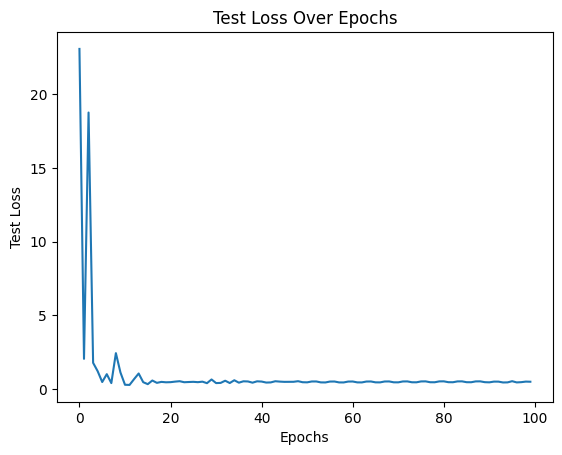

In [10]:
# Run the main function
if __name__ == "__main__":

    #print('OPTIONS ', options)
    # Tuning Parameters:
    import easydict
    from argparse import ArgumentParser
    parser = ArgumentParser()
    args = parser.parse_known_args()[0]
    #使用 easydict，可以创建一个命名空间对象，该对象具有字典的功能，并允许通过点号操作符来访问和设置键值对。
    args = easydict.EasyDict({
            "num_epochs": 100,
            "batch_size": 1,
            "lr": 0.0005,
            "tb_dir": "./runs",
            "final": False,
            "max_pool": False,
            "embedding_size" : 768,
            "vocab_size" : 50000,
            "max_length" : 520,
            "num_heads" : 2,
            "depth" : 1,
            "seed" : 1,
            "lr_warmup" : 500,
            "gradient_clipping" : 1.0
    })
    evaluation = go(args)

    epoch_numbers = evaluation['epoch']
    test_accuracies = evaluation['Test Accuracy']

    # 将数据转换为 NumPy 数组
    epoch_numbers = np.array(epoch_numbers)
    test_accuracies = np.array(test_accuracies)

    # 获取排序后的索引
    sorted_indices = np.argsort(epoch_numbers)

    # 根据排序后的索引获取排序后的数据
    sorted_epoch_numbers = epoch_numbers[sorted_indices]
    sorted_test_accuracies = test_accuracies[sorted_indices]

    # 绘制迭代MSE折线图
    plt.plot(sorted_epoch_numbers, sorted_test_accuracies)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')  # 或者 'Test Accuracy'，具体根据你的情况来确定
    plt.title('Test Loss Over Epochs')
    plt.show()